In [1]:

import torch
import random
import numpy as np

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)  


In [2]:
# SECTION 1: Dataset and Triplet Sampling

import os
import random
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Dataset Root Path
DATASET_PATH = r"D:\Master's Research\unified_dataset\final_sex"
# Define Folds and Paths
FOLDS = [f"fold_{i}" for i in range(1, 6)]
TEST_PATH = os.path.join(DATASET_PATH, "test", "images")

# Image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    #transforms.RandomHorizontalFlip(),  # Data augmentation
    #transforms.RandomRotation(10),  
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet stats
])


In [3]:
class TripletDataset(Dataset):
    def __init__(self, data_path, transform=None):
        self.image_paths = []
        self.labels = []
        self.transform = transform

        for root, _, files in os.walk(data_path):
            for file in files:
                if file.lower().endswith((".jpg", ".jpeg", ".png")):
                    full_path = os.path.join(root, file)
                    if os.path.isfile(full_path):  # avoid directory bugs
                        self.image_paths.append(full_path)

                        
                        sex_label = os.path.basename(os.path.dirname(os.path.dirname(full_path)))
                        self.labels.append(sex_label)

                
    def __getitem__(self, index):
        anchor_path = self.image_paths[index]
        anchor_label = self.labels[index]
        
        # Positive sample
        positive_candidates = [p for p, l in zip(self.image_paths, self.labels) 
                               if l == anchor_label and p != anchor_path]
        positive_path = random.choice(positive_candidates) if positive_candidates else anchor_path
        
        # Semi-Hard Negative sample
        negative_candidates = [p for p, l in zip(self.image_paths, self.labels) 
                               if l != anchor_label]
        negative_path = random.choice(negative_candidates) if negative_candidates else random.choice(self.image_paths)
        
        anchor = self.transform(Image.open(anchor_path).convert("RGB"))
        positive = self.transform(Image.open(positive_path).convert("RGB"))
        negative = self.transform(Image.open(negative_path).convert("RGB"))
        
        return anchor, positive, negative

    def __len__(self):
        return len(self.image_paths)


In [4]:
# Denormalization Function
def denormalize(img):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img = img * std + mean  # Reverse normalization
    img = torch.clamp(img, 0, 1)  # Ensure values are in [0, 1]
    return img

# Visualize One Triplet
def visualize_triplet(dataset, index=0):
    anchor, positive, negative = dataset[index]
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(denormalize(anchor).permute(1, 2, 0))
    axes[0].set_title("Anchor")
    axes[1].imshow(denormalize(positive).permute(1, 2, 0))
    axes[1].set_title("Positive")
    axes[2].imshow(denormalize(negative).permute(1, 2, 0))
    axes[2].set_title("Negative")
    
    for ax in axes:
        ax.axis("off")
    plt.show()

# Display a Sample Triplet
#visualize_triplet(train_dataset, index=5)


In [5]:
# SECTION 2: Model Architecture

import torch
import torch.nn as nn
import torchvision.models as models

class VGG11Triplet(nn.Module):
    def __init__(self, embedding_dim=256):
        """
        VGG11 Backbone with a custom embedding layer.
        
        Args:
            embedding_dim (int): Dimension of the embedding vector.
        """
        super(VGG11Triplet, self).__init__()
        
        # Load pre-trained VGG11 model
        self.base_model = models.vgg11(pretrained=True)
        
        # Remove the final classification layer
        self.base_model.classifier = nn.Sequential(*list(self.base_model.classifier.children())[:-1])
        
        # Add a custom embedding layer
        self.embedding_layer = nn.Linear(4096, embedding_dim)
    
    def forward(self, x):
        """
        Forward pass through VGG11 and embedding layer.
        
        Args:
            x (Tensor): Input image tensor.
        
        Returns:
            Tensor: L2-normalized embedding vector.
        """
        x = self.base_model.features(x)  # Feature extraction
        x = torch.flatten(x, 1)  # Flatten to a vector
        x = self.base_model.classifier(x)  # Pass through modified classifier
        x = self.embedding_layer(x)  # Generate embeddings
        return nn.functional.normalize(x, p=2, dim=1)  # L2 normalization


In [6]:
# Initialize Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VGG11Triplet(embedding_dim=256).to(device)

# Print Model Summary
from torchsummary import summary
summary(model, (3, 224, 224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
         MaxPool2d-3         [-1, 64, 112, 112]               0
            Conv2d-4        [-1, 128, 112, 112]          73,856
              ReLU-5        [-1, 128, 112, 112]               0
         MaxPool2d-6          [-1, 128, 56, 56]               0
            Conv2d-7          [-1, 256, 56, 56]         295,168
              ReLU-8          [-1, 256, 56, 56]               0
            Conv2d-9          [-1, 256, 56, 56]         590,080
             ReLU-10          [-1, 256, 56, 56]               0
        MaxPool2d-11          [-1, 256, 28, 28]               0
           Conv2d-12          [-1, 512, 28, 28]       1,180,160
             ReLU-13          [-1, 512, 28, 28]               0
           Conv2d-14          [-1, 512,

In [7]:
'''
# Sample Data
sample_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
sample_batch = next(iter(sample_loader))
anchor, positive, negative = sample_batch

# Move to device
anchor = anchor.to(device)
positive = positive.to(device)
negative = negative.to(device)

# Get Embeddings
with torch.no_grad():
    anchor_emb = model(anchor)
    positive_emb = model(positive)
    negative_emb = model(negative)

# Display Embedding Vectors
print("Anchor Embedding Sample:\n", anchor_emb[0])
print("\nPositive Embedding Sample:\n", positive_emb[0])
print("\nNegative Embedding Sample:\n", negative_emb[0])
'''

'\n# Sample Data\nsample_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)\nsample_batch = next(iter(sample_loader))\nanchor, positive, negative = sample_batch\n\n# Move to device\nanchor = anchor.to(device)\npositive = positive.to(device)\nnegative = negative.to(device)\n\n# Get Embeddings\nwith torch.no_grad():\n    anchor_emb = model(anchor)\n    positive_emb = model(positive)\n    negative_emb = model(negative)\n\n# Display Embedding Vectors\nprint("Anchor Embedding Sample:\n", anchor_emb[0])\nprint("\nPositive Embedding Sample:\n", positive_emb[0])\nprint("\nNegative Embedding Sample:\n", negative_emb[0])\n'

In [8]:
# SECTION 3: Triplet Loss

import torch
import torch.nn as nn
import torch.nn.functional as F

class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        """
        Triplet Loss for embedding learning.
        
        Args:
            margin (float): Margin value to enforce separation between positive and negative pairs.
        """
        super(TripletLoss, self).__init__()
        self.margin = margin
    
    def forward(self, anchor, positive, negative):
        """
        Args:
            anchor (Tensor): Anchor embeddings.
            positive (Tensor): Positive embeddings (same class as anchor).
            negative (Tensor): Negative embeddings (different class from anchor).
        
        Returns:
            Tensor: Triplet loss value.
        """
        pos_distance = F.pairwise_distance(anchor, positive)  # Distance between anchor and positive
        neg_distance = F.pairwise_distance(anchor, negative)  # Distance between anchor and negative
        
        loss = torch.clamp(pos_distance - neg_distance + self.margin, min=0.0).mean()
        return loss


In [9]:
'''import seaborn as sns
import matplotlib.pyplot as plt

# Calculate distances
pos_distances = F.pairwise_distance(anchor, positive).cpu().detach().numpy()
neg_distances = F.pairwise_distance(anchor, negative).cpu().detach().numpy()

# Plot distances
plt.figure(figsize=(12, 6))
sns.histplot(pos_distances, kde=True, color='b', label='Positive Distances')
sns.histplot(neg_distances, kde=True, color='r', label='Negative Distances')
plt.axvline(x=1.0, color='k', linestyle='--', label='Margin')
plt.title('Distribution of Positive and Negative Distances')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.legend()
plt.show()
'''

"import seaborn as sns\nimport matplotlib.pyplot as plt\n\n# Calculate distances\npos_distances = F.pairwise_distance(anchor, positive).cpu().detach().numpy()\nneg_distances = F.pairwise_distance(anchor, negative).cpu().detach().numpy()\n\n# Plot distances\nplt.figure(figsize=(12, 6))\nsns.histplot(pos_distances, kde=True, color='b', label='Positive Distances')\nsns.histplot(neg_distances, kde=True, color='r', label='Negative Distances')\nplt.axvline(x=1.0, color='k', linestyle='--', label='Margin')\nplt.title('Distribution of Positive and Negative Distances')\nplt.xlabel('Distance')\nplt.ylabel('Frequency')\nplt.legend()\nplt.show()\n"

In [10]:
# SECTION 4: Training Loop

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Ensure device availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# DataLoader for Training and Validation
train_dataset = TripletDataset(os.path.join(DATASET_PATH, "fold_1", "train", "images"), transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

#original path
val_loader = DataLoader(
    TripletDataset(os.path.join(DATASET_PATH, "fold_1", "val", "images"), transform), 
    batch_size=16, shuffle=False
)

In [11]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0.001):
        self.patience = patience
        self.delta = delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False
    
    def __call__(self, val_loss):
        if self.best_loss is None or val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True


In [12]:
# Model Definition
model = VGG11Triplet(embedding_dim=512).to(device)  # Increased embedding dimension

# Criterion: Adjust Triplet Loss Margin
criterion = nn.TripletMarginLoss(margin=0.2, p=2).to(device)  # Lower margin

# Optimizer and Scheduler
optimizer = optim.Adam(model.parameters(), lr=1e-5)  # Lower learning rate
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)  # Reduced step_size for scheduler


In [13]:
def train(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=50):
    """
    Train and validate the Triplet Network.
    
    Args:
        model: VGG11Triplet model instance.
        train_loader: DataLoader for training data.
        val_loader: DataLoader for validation data.
        criterion: TripletLoss instance.
        optimizer: Optimizer for updating weights.
        scheduler: Learning rate scheduler.
        epochs: Number of training epochs.
    
    Returns:
        train_losses (list): List of average training loss per epoch.
        val_losses (list): List of average validation loss per epoch.
    """
    train_losses = []
    val_losses = []
    early_stopping = EarlyStopping(patience=8)
    
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        
        for anchor, positive, negative in train_loader:
            anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)
            optimizer.zero_grad()
            anchor_emb = model(anchor)
            positive_emb = model(positive)
            negative_emb = model(negative)
            loss = criterion(anchor_emb, positive_emb, negative_emb)
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Prevent exploding gradients
            
            optimizer.step()
            total_train_loss += loss.item()
        
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validation Step
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for anchor, positive, negative in val_loader:
                anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)
                anchor_emb = model(anchor)
                positive_emb = model(positive)
                negative_emb = model(negative)
                loss = criterion(anchor_emb, positive_emb, negative_emb)
                total_val_loss += loss.item()
        
        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        scheduler.step()
        
        print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
        
        early_stopping(avg_val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered!")
            break
    
    return train_losses, val_losses



In [14]:
# Train the model
epochs = 50
train_losses, val_losses = train(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs)


Epoch [1/50] - Train Loss: 0.1974, Val Loss: 0.1961
Epoch [2/50] - Train Loss: 0.1984, Val Loss: 0.1859
Epoch [3/50] - Train Loss: 0.1945, Val Loss: 0.1798
Epoch [4/50] - Train Loss: 0.1903, Val Loss: 0.1698
Epoch [5/50] - Train Loss: 0.1687, Val Loss: 0.1397
Epoch [6/50] - Train Loss: 0.1366, Val Loss: 0.1470
Epoch [7/50] - Train Loss: 0.0977, Val Loss: 0.1179
Epoch [8/50] - Train Loss: 0.0651, Val Loss: 0.1168
Epoch [9/50] - Train Loss: 0.0320, Val Loss: 0.1014
Epoch [10/50] - Train Loss: 0.0200, Val Loss: 0.0972
Epoch [11/50] - Train Loss: 0.0096, Val Loss: 0.0987
Epoch [12/50] - Train Loss: 0.0057, Val Loss: 0.1117
Epoch [13/50] - Train Loss: 0.0038, Val Loss: 0.1128
Epoch [14/50] - Train Loss: 0.0022, Val Loss: 0.1051
Epoch [15/50] - Train Loss: 0.0013, Val Loss: 0.0902
Epoch [16/50] - Train Loss: 0.0011, Val Loss: 0.1065
Epoch [17/50] - Train Loss: 0.0008, Val Loss: 0.1061
Epoch [18/50] - Train Loss: 0.0009, Val Loss: 0.1225
Epoch [19/50] - Train Loss: 0.0006, Val Loss: 0.1031
Ep

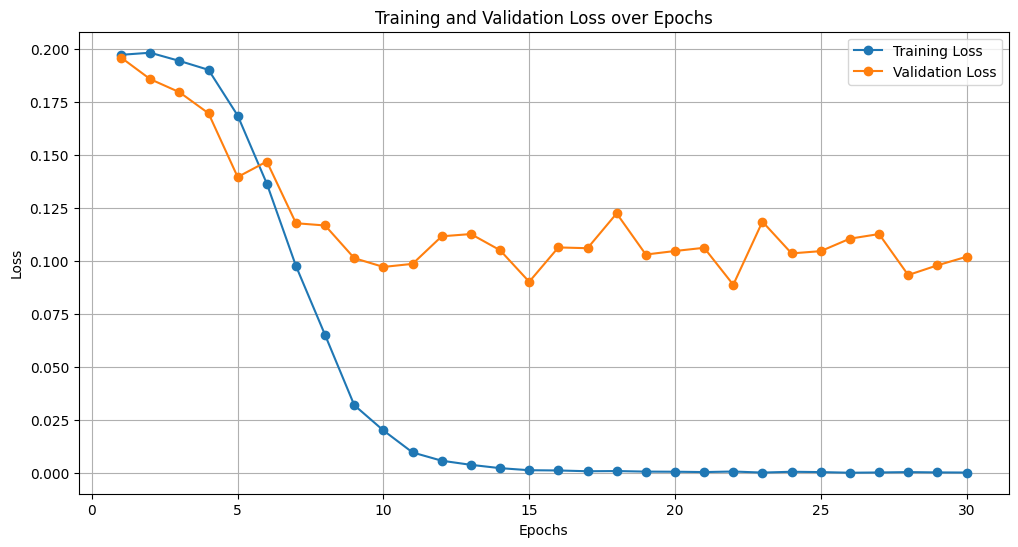

In [15]:

epochs_ran = len(train_losses)

plt.figure(figsize=(12, 6))
plt.plot(range(1, epochs_ran + 1), train_losses, label='Training Loss', marker='o')
plt.plot(range(1, epochs_ran + 1), val_losses, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [16]:

# Define Model Save Path
MODEL_DIR = r"D:\Master's Research\VGG11+triplet_loss\models"
MODEL_SAVE_PATH = os.path.join(MODEL_DIR, "vgg11_triplet_sex_model.pth")

# Create the directory if it doesn't exist
os.makedirs(MODEL_DIR, exist_ok=True)

# Save the trained model
torch.save(model.state_dict(), MODEL_SAVE_PATH)
print(f"Model saved successfully to {MODEL_SAVE_PATH}")


Model saved successfully to D:\Master's Research\VGG11+triplet_loss\models\vgg11_triplet_sex_model.pth


In [17]:
# SECTION 5: Evaluation Metrics

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

def extract_embeddings_and_labels(model, dataset):
    """
    Extract embeddings and labels from a dataset.
    
    Args:
        model: Trained embedding model.
        dataset: Dataset to extract embeddings from.
    
    Returns:
        embeddings (np.array): Numpy array of extracted embeddings.
        labels (list): Corresponding labels.
    """
    model.eval()
    embeddings = []
    labels = []
    
    with torch.no_grad():
        for indices, (anchor, _, _) in enumerate(DataLoader(dataset, batch_size=16)):
            anchor = anchor.to(device)
            emb = model(anchor).cpu().numpy()
            embeddings.append(emb)
            labels.extend([dataset.labels[idx] for idx in range(indices * 16, indices * 16 + len(emb))])
    
    return np.vstack(embeddings), labels

In [18]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd

def plot_and_save_normalized_confusion_matrix(true_labels, pred_labels, class_names, dataset_name, save_path):
    num_classes = len(class_names)
    labels = list(range(num_classes))

    cm = confusion_matrix(true_labels, pred_labels, labels=class_names)
    cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)
    cm_norm = np.nan_to_num(cm_norm)

    # Save as CSV
    df_cm = pd.DataFrame(cm_norm, index=class_names, columns=class_names)
    df_cm.to_csv(save_path + ".csv", index=True)
    print(f" Saved normalized confusion matrix CSV for {dataset_name} at: {save_path}.csv")

    # Save as PNG
    plt.figure(figsize=(24, 20))  # Increase overall figure size
    sns.heatmap(cm_norm, 
                annot=True, fmt=".2f", cmap="Blues",
                xticklabels=class_names, 
                yticklabels=class_names,
                square=True,
                cbar_kws={"label": "Proportion (0–1)"},
                annot_kws={"size": 6})  # Smaller annotation text
    plt.title(f"{dataset_name} (Normalized)", fontsize=18)
    plt.xlabel("Predicted", fontsize=14)
    plt.ylabel("True", fontsize=14)
    plt.xticks(rotation=90, fontsize=8)
    plt.yticks(rotation=0, fontsize=8)
    plt.tight_layout()

    plt.savefig(save_path + ".png")
    plt.close()
    print(f"Saved normalized confusion matrix PNG for {dataset_name} at: {save_path}.png")


#  Collect All Class Labels from Dataset Structure
def get_all_classes_from_dataset(base_path):
    all_classes = set()
    for split in ["train", "val", "test"]:
        split_path = os.path.join(base_path, split, "images")
        if os.path.exists(split_path):
            class_dirs = [d for d in os.listdir(split_path)
                          if os.path.isdir(os.path.join(split_path, d))]
            all_classes.update(class_dirs)
    return sorted(list(all_classes))

# Collect from all splits
all_class_labels = get_all_classes_from_dataset(DATASET_PATH)
print("All Class Labels from Full Dataset:", all_class_labels)
print("Total Unique Classes:", len(all_class_labels))

# Fit LabelEncoder on all classes
label_encoder = LabelEncoder()
label_encoder.fit(all_class_labels)

#  Fit LabelEncoder with All Classes
label_encoder = LabelEncoder()
label_encoder.fit(all_class_labels)
print("Encoded Classes:", label_encoder.classes_)
print("Number of Encoded Classes:", len(label_encoder.classes_))

#  Load Test Dataset
test_dataset = TripletDataset(os.path.join(DATASET_PATH, "test", "images"), transform)

#  Extract Test Embeddings and Labels
test_embeddings, test_labels = extract_embeddings_and_labels(model, test_dataset)

#  Encode Labels Using the Updated LabelEncoder
encoded_labels = label_encoder.transform(test_labels)

# Train k-NN Classifier
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
knn.fit(test_embeddings, encoded_labels)

#  Make Predictions
predictions = knn.predict(test_embeddings)
decoded_preds = label_encoder.inverse_transform(predictions)
decoded_labels = label_encoder.inverse_transform(encoded_labels)

def evaluate_set(name, dataset, model, label_encoder):
    print(f"\n Evaluating {name} Set")

    embeddings, labels = extract_embeddings_and_labels(model, dataset)
    encoded_labels = label_encoder.transform(labels)

    knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
    knn.fit(embeddings, encoded_labels)
    predictions = knn.predict(embeddings)

    decoded_preds = label_encoder.inverse_transform(predictions)
    decoded_labels = label_encoder.inverse_transform(encoded_labels)

    acc = accuracy_score(decoded_labels, decoded_preds)
    prec = precision_score(decoded_labels, decoded_preds, average='weighted', zero_division=0)
    rec = recall_score(decoded_labels, decoded_preds, average='weighted', zero_division=0)
    f1 = f1_score(decoded_labels, decoded_preds, average='weighted', zero_division=0)

    print(f" {name} Accuracy: {acc:.4f}")
    print(f" {name} Precision: {prec:.4f}")
    print(f" {name} Recall: {rec:.4f}")
    print(f" {name} F1-score: {f1:.4f}")

    # Classification report to CSV only
    df_report = pd.DataFrame(classification_report(
        decoded_labels, decoded_preds,
        output_dict=True,
        zero_division=0)).transpose()

    csv_path = os.path.join(output_dir, f"{name}_classification_report.csv")
    df_report.to_csv(csv_path)
    print(f" Saved {name} classification report CSV to: {csv_path}")

    # Normalized confusion matrix
    cm_save_path = os.path.join(output_dir, f"{name}_normalized_confusion_matrix")
    plot_and_save_normalized_confusion_matrix(decoded_labels, decoded_preds,
                                              list(label_encoder.classes_),
                                              f"{name} Set",
                                              cm_save_path)

#FOR SEX AND AGE
# === Sex and Age Classification ===
def evaluate_attribute(name, labels_dict, embeddings, individual_labels):
    print(f"\n Evaluating {name} Classification")

    attribute_labels = [labels_dict[ind] for ind in individual_labels if ind in labels_dict]
    filtered_embeddings = [embeddings[i] for i, ind in enumerate(individual_labels) if ind in labels_dict]
    filtered_embeddings = np.array(filtered_embeddings)

    if not attribute_labels:
        print(f"No matching individuals found for {name} evaluation.")
        return

    le = LabelEncoder()
    encoded_labels = le.fit_transform(attribute_labels)

    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(filtered_embeddings, encoded_labels)
    predictions = knn.predict(filtered_embeddings)

    decoded_preds = le.inverse_transform(predictions)
    decoded_labels = le.inverse_transform(encoded_labels)

    acc = accuracy_score(decoded_labels, decoded_preds)
    prec = precision_score(decoded_labels, decoded_preds, average='weighted', zero_division=0)
    rec = recall_score(decoded_labels, decoded_preds, average='weighted', zero_division=0)
    f1 = f1_score(decoded_labels, decoded_preds, average='weighted', zero_division=0)

    print(f" {name} Accuracy: {acc:.4f}")
    print(f" {name} Precision: {prec:.4f}")
    print(f" {name} Recall: {rec:.4f}")
    print(f" {name} F1-score: {f1:.4f}")

    # Report CSV only
    df_report = pd.DataFrame(classification_report(
        decoded_labels, decoded_preds,
        output_dict=True,
        zero_division=0)).transpose()

    report_path_csv = os.path.join(output_dir, f"{name}_classification_report.csv")
    df_report.to_csv(report_path_csv)
    print(f" Saved {name} report CSV to: {report_path_csv}")

    # Normalized Confusion Matrix
    cm_save_path = os.path.join(output_dir, f"{name}_normalized_confusion_matrix")
    plot_and_save_normalized_confusion_matrix(decoded_labels, decoded_preds,
                                              list(le.classes_),
                                              f"{name} Classification",
                                              cm_save_path)

# Run for all three sets
output_dir = r"D:\Master's Research\VGG11+triplet_loss\sex_results_updated"
os.makedirs(output_dir, exist_ok=True)


test_embeddings, test_labels = extract_embeddings_and_labels(model, test_dataset)
# Only evaluate sex Group
evaluate_set("Train", train_dataset, model, label_encoder)
evaluate_set("Validation", val_loader.dataset, model, label_encoder)
evaluate_set("Test", test_dataset, model, label_encoder)


All Class Labels from Full Dataset: ['Female', 'Male']
Total Unique Classes: 2
Encoded Classes: ['Female' 'Male']
Number of Encoded Classes: 2

 Evaluating Train Set
 Train Accuracy: 1.0000
 Train Precision: 1.0000
 Train Recall: 1.0000
 Train F1-score: 1.0000
 Saved Train classification report CSV to: D:\Master's Research\VGG11+triplet_loss\sex_results_updated\Train_classification_report.csv
 Saved normalized confusion matrix CSV for Train Set at: D:\Master's Research\VGG11+triplet_loss\sex_results_updated\Train_normalized_confusion_matrix.csv
Saved normalized confusion matrix PNG for Train Set at: D:\Master's Research\VGG11+triplet_loss\sex_results_updated\Train_normalized_confusion_matrix.png

 Evaluating Validation Set
 Validation Accuracy: 0.8884
 Validation Precision: 0.8892
 Validation Recall: 0.8884
 Validation F1-score: 0.8883
 Saved Validation classification report CSV to: D:\Master's Research\VGG11+triplet_loss\sex_results_updated\Validation_classification_report.csv
 Saved 

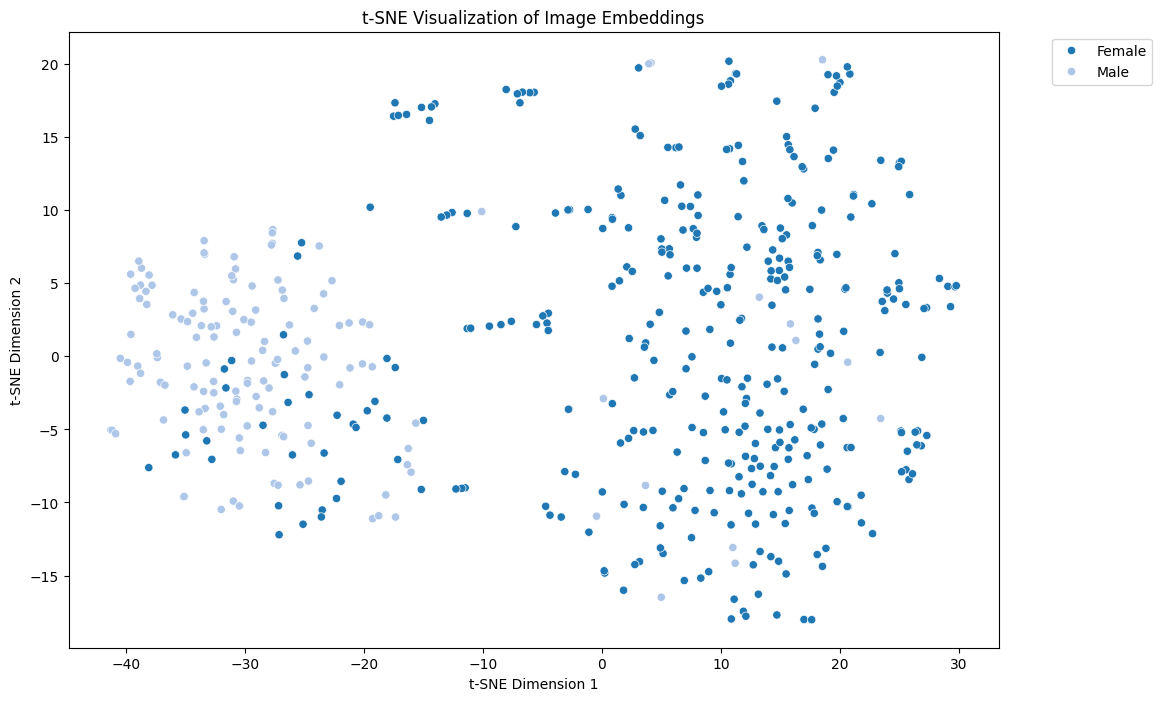

In [19]:
# t-SNE Visualization of Embeddings
def plot_tsne(embeddings, labels):
    """
    Visualize embeddings using t-SNE.
    
    Args:
        embeddings (np.array): Array of image embeddings.
        labels (list): Corresponding labels for the embeddings.
    """
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    reduced_embeddings = tsne.fit_transform(embeddings)
    
    plt.figure(figsize=(12, 8))
    sns.scatterplot(
        x=reduced_embeddings[:, 0],
        y=reduced_embeddings[:, 1],
        hue=labels,
        palette='tab20',
        legend='full'
    )
    plt.title('t-SNE Visualization of Image Embeddings')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

# Plot Embeddings
plot_tsne(test_embeddings, test_labels)


In [20]:
from scipy.spatial.distance import cosine

def identify_individual(query_img_path, model, gallery_embeddings, gallery_labels):
    """
    Identify the individual using cosine similarity.
    
    Args:
        query_img_path (str): Path to the query image.
        model: Trained model.
        gallery_embeddings (np.array): Stored embeddings of gallery images.
        gallery_labels (list): Corresponding labels.
    
    Returns:
        str: Predicted label.
    """
    query_img = transform(Image.open(query_img_path).convert("RGB")).unsqueeze(0).to(device)
    query_embedding = model(query_img).cpu().detach().numpy()
    
    distances = [cosine(query_embedding, emb) for emb in gallery_embeddings]
    predicted_label = gallery_labels[np.argmin(distances)]
    return predicted_label


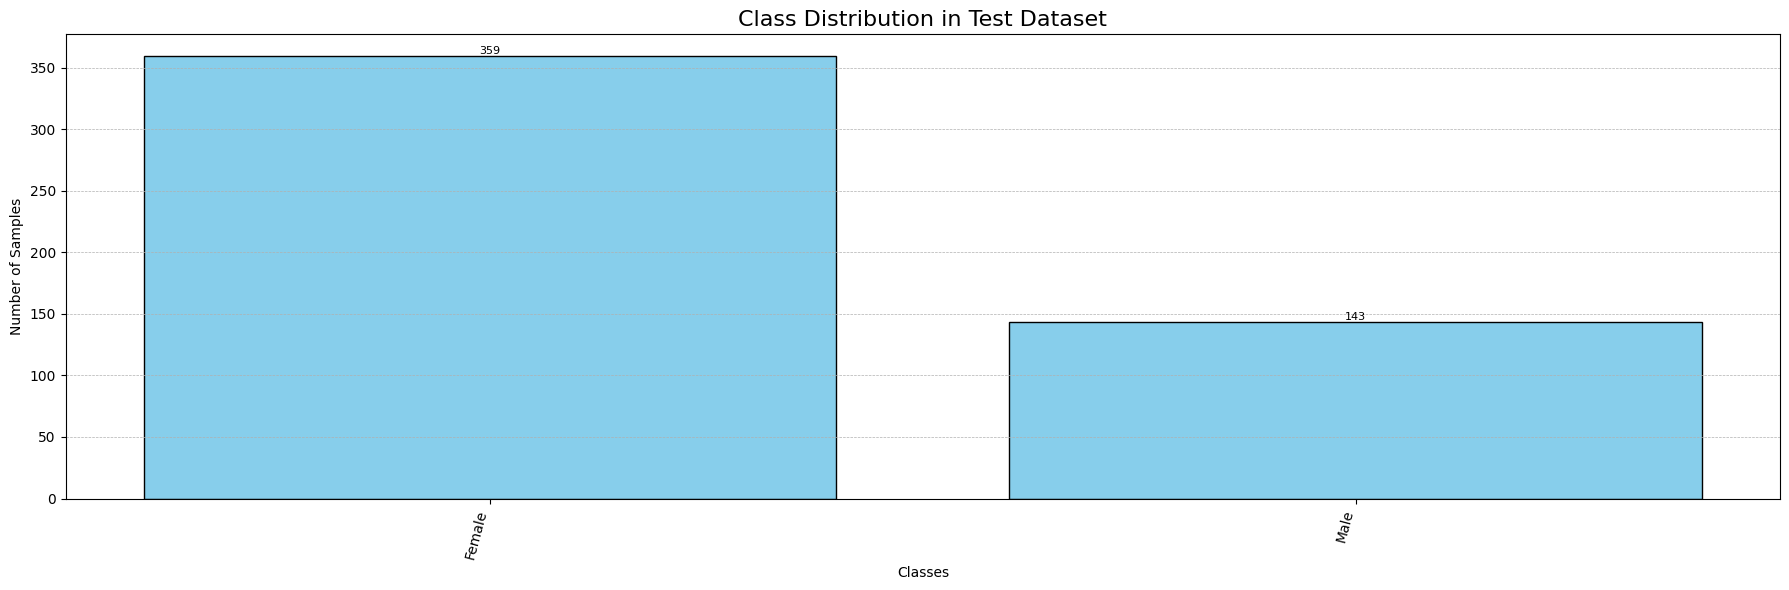

In [21]:
from collections import Counter
import matplotlib.pyplot as plt

# Count class samples
class_counts = Counter(test_labels)
classes = list(class_counts.keys())
counts = list(class_counts.values())

# Plot
plt.figure(figsize=(18, 6))
bars = plt.bar(classes, counts, color='skyblue', edgecolor='black')

# Add value labels on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.5, int(yval), ha='center', va='bottom', fontsize=8)

plt.title('Class Distribution in Test Dataset', fontsize=16)
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.xticks(rotation=75, ha='right')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.show()


In [22]:

from sklearn.metrics.pairwise import cosine_similarity
import cv2
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

def infer_image(image_path, model, gallery_embeddings, gallery_labels, sex_map, age_map):
    """
    Predict individual, sex, and age group from a new image using the trained model.
    """
    if not os.path.exists(image_path):
        print("❌ Image path does not exist.")
        return

    model.eval()
    img = Image.open(image_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        query_embedding = model(img_tensor).cpu().numpy()[0]

    # Cosine similarity against gallery embeddings
    similarities = cosine_similarity([query_embedding], gallery_embeddings)[0]
    best_idx = np.argmax(similarities)
    predicted_individual = gallery_labels[best_idx]

    # Lookup sex and age
    predicted_sex = sex_map.get(predicted_individual, "Unknown")
    predicted_age = age_map.get(predicted_individual, "Unknown")

    print("\n Inference Result:")
    print(f"→ Image: {os.path.basename(image_path)}")
    print(f" Predicted Devil: {predicted_individual}")
    print(f" Predicted Sex: {predicted_sex}")
    print(f" Predicted Age Group: {predicted_age}")

    return {
        "image": os.path.basename(image_path),
        "individual": predicted_individual,
        "sex": predicted_sex,
        "age_group": predicted_age
    }

# Extract embeddings from train set for gallery
train_embeddings, train_labels = extract_embeddings_and_labels(model, train_dataset)

# Inference example
sample_path = r"D:\Master's Research\unified_dataset\cropped_devils\Caipi\Caipi_release_frame_0328_crop_0.jpg"
infer_image(sample_path, model, train_embeddings, train_labels, individual_to_sex, individual_to_age)


NameError: name 'individual_to_sex' is not defined